In [1]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning Models
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam

# Performance Metrics
from sklearn.metrics import classification_report, confusion_matrix

# Utilities
import os
import joblib
import glob

# Phase 1: Data Loading

Load Dataset

In [2]:
# Main dataset directory
DATASET_DIR = r"data"

# Subfolders for train, validation, and test
TRAIN_DIR   = os.path.join(DATASET_DIR, "Train")
VAL_DIR     = os.path.join(DATASET_DIR, "Validation")
TEST_DIR    = os.path.join(DATASET_DIR, "Test")

# Check if the folders exist
print("Train exists:", os.path.exists(TRAIN_DIR))
print("Validation exists:", os.path.exists(VAL_DIR))
print("Test exists:", os.path.exists(TEST_DIR))

Train exists: True
Validation exists: True
Test exists: True


In [3]:
# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 8  # Reduced from 32 to avoid memory issues with ResNet50
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
# Load train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

Found 10000 files belonging to 2 classes.


In [5]:
# Check shape of one batch
for images, labels in train_ds.take(1):
    print("Train batch images shape:", images.shape)
    print("Train batch labels shape:", labels.shape)

Train batch images shape: (8, 224, 224, 3)
Train batch labels shape: (8,)


In [6]:
# Load test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 992 files belonging to 2 classes.


In [7]:
# Check shape of one batch
for images, labels in test_ds.take(1):
    print("Test batch images shape:", images.shape)
    print("Test batch labels shape:", labels.shape)

Test batch images shape: (8, 224, 224, 3)
Test batch labels shape: (8,)


In [8]:
# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

Found 800 files belonging to 2 classes.


In [9]:
# Check shape of one batch
for images, labels in val_ds.take(1):
    print("Validation batch images shape:", images.shape)
    print("Validation batch labels shape:", labels.shape)

Validation batch images shape: (8, 224, 224, 3)
Validation batch labels shape: (8,)


# Phase 2: Data Visualization


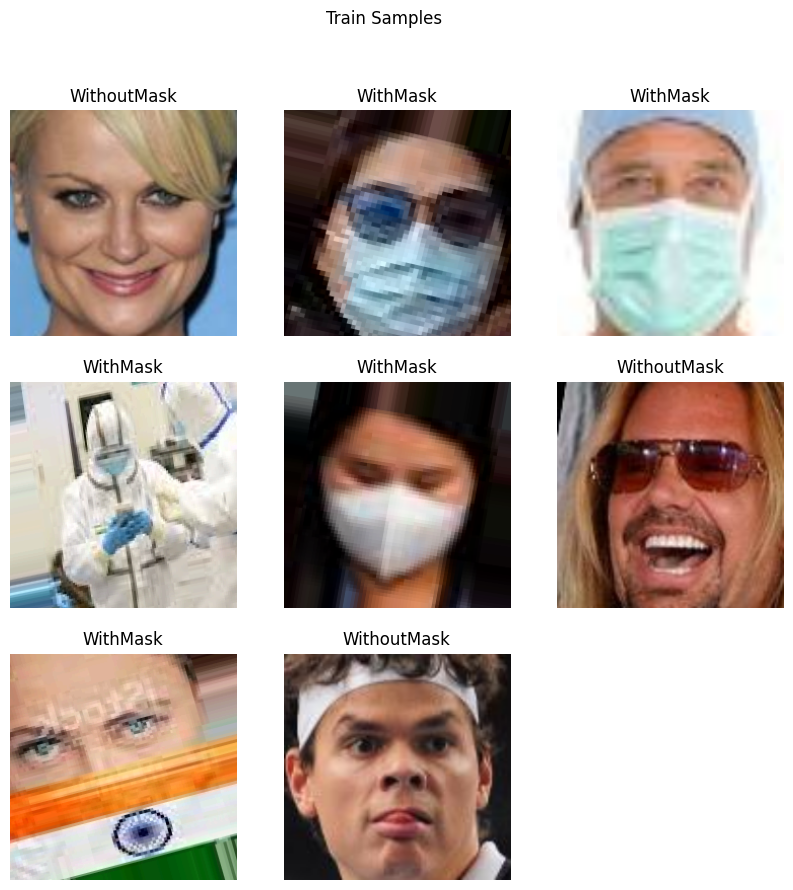

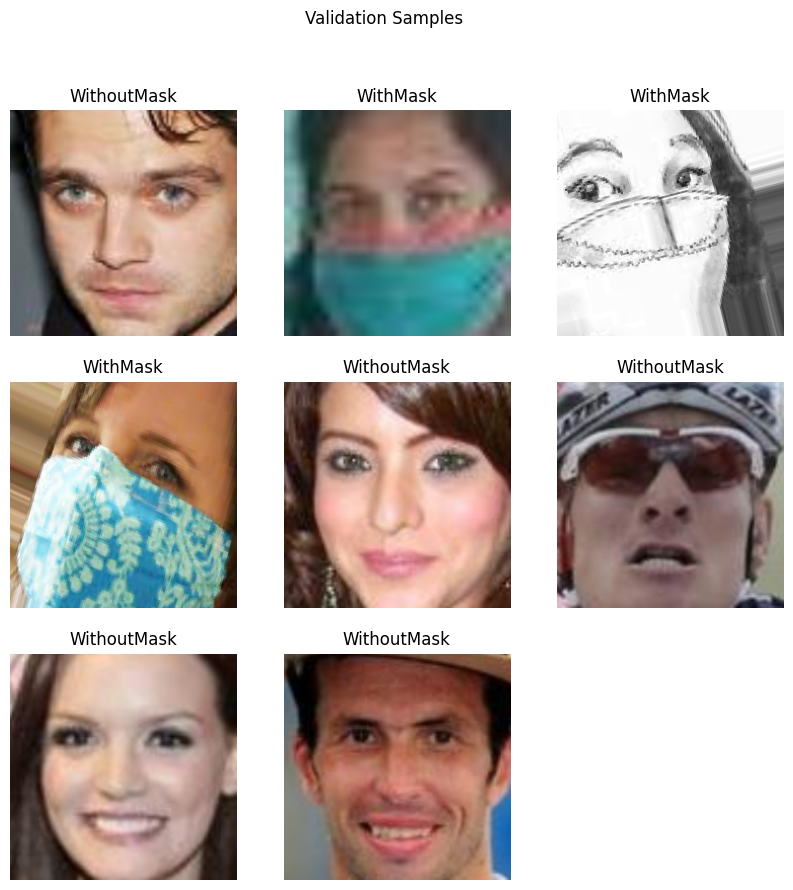

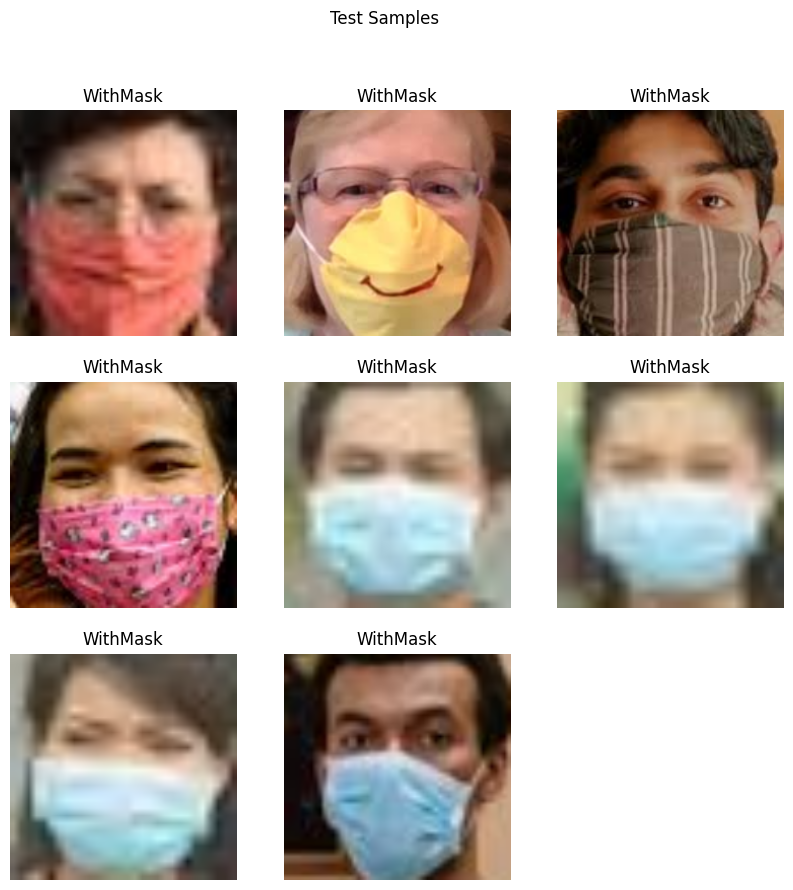

In [10]:
def show_samples(ds, title):
    class_names = ds.class_names
    plt.figure(figsize=(10,10))
    for images, labels in ds.take(1):
        for i in range(8):
            ax = plt.subplot(3,3,i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_samples(train_ds, "Train Samples")
show_samples(val_ds, "Validation Samples")
show_samples(test_ds, "Test Samples")

### Plot class distribution

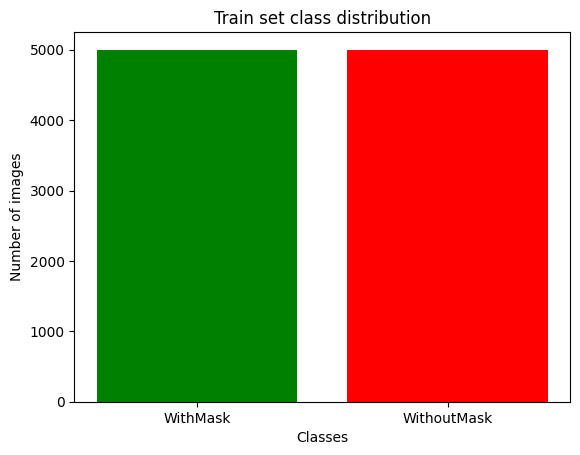

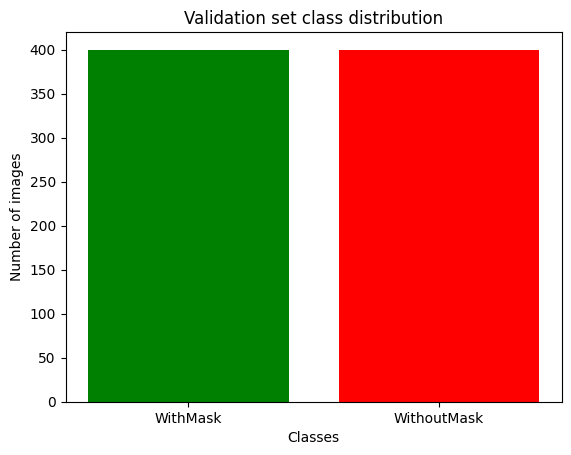

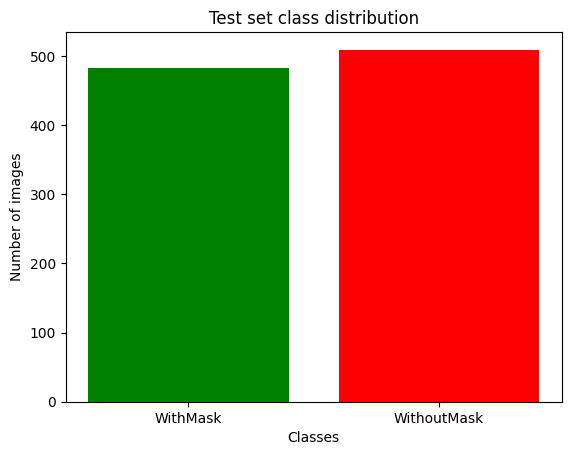

In [11]:
def plot_distribution(directory, labels, title):
    counts = [len(glob.glob(os.path.join(directory, cls, "*"))) for cls in labels]
    plt.bar(labels, counts, color=['green','red'])
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Number of images")
    plt.show()

labels = ["WithMask", "WithoutMask"]
plot_distribution(TRAIN_DIR, labels, "Train set class distribution")
plot_distribution(VAL_DIR, labels, "Validation set class distribution")
plot_distribution(TEST_DIR, labels, "Test set class distribution")

# Phase 3: Data Preprocessing & Augmentation

In [12]:
# Data Augmentation for CNN (tf layers) - Fixed to maintain image dimensions
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15, fill_mode="constant")  # Use constant fill to maintain size
])

 Preprocessing functions

In [13]:
# For CNN from scratch
def preprocess_cnn(image, label):
    image = image / 255.0
    return image, label

In [14]:
# For MobileNetV2
def preprocess_mobilenet(image, label):
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

In [15]:
# For ResNet50
def preprocess_resnet(image, label):
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

Apply preprocessing + augmentation

In [16]:
# CNN dataset
train_ds_cnn = train_ds.map(preprocess_cnn).map(lambda x, y: (data_augmentation(x, training=True), y))
val_ds_cnn   = val_ds.map(preprocess_cnn)
test_ds_cnn  = test_ds.map(preprocess_cnn)

In [17]:
# MobileNet dataset
train_ds_mobilenet = train_ds.map(preprocess_mobilenet)
val_ds_mobilenet   = val_ds.map(preprocess_mobilenet)
test_ds_mobilenet  = test_ds.map(preprocess_mobilenet)

In [18]:
# ResNet dataset
train_ds_resnet = train_ds.map(preprocess_resnet)
val_ds_resnet   = val_ds.map(preprocess_resnet)
test_ds_resnet  = test_ds.map(preprocess_resnet)

 Performance optimization

In [19]:
def optimize_dataset(ds):
    return ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds_cnn = optimize_dataset(train_ds_cnn)
val_ds_cnn   = optimize_dataset(val_ds_cnn)
test_ds_cnn  = optimize_dataset(test_ds_cnn)

train_ds_mobilenet = optimize_dataset(train_ds_mobilenet)
val_ds_mobilenet   = optimize_dataset(val_ds_mobilenet)
test_ds_mobilenet  = optimize_dataset(test_ds_mobilenet)

train_ds_resnet = optimize_dataset(train_ds_resnet)
val_ds_resnet   = optimize_dataset(val_ds_resnet)
test_ds_resnet  = optimize_dataset(test_ds_resnet)

# Phase 4: Building Models

In [20]:
# CNN from scratch (with built-in augmentation) - Rebuild to fix dimensions
cnn_model = models.Sequential([
    layers.Input(shape=(224,224,3)),
    data_augmentation,  # Add augmentation as first layer
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # 2 classes
])

# Print model summary to verify architecture
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,218 (42.61 MB)

 Trainable params: 11,169,218 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
cnn_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Transfer Learning

In [22]:
# MobileNetV2
base_mobilenet = MobileNetV2(input_shape=(224,224,3),
                             include_top=False,
                             weights='imagenet')
base_mobilenet.trainable = False  # freeze base

mobilenet_model = models.Sequential([
    base_mobilenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

In [23]:
mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
# ResNet50
base_resnet = ResNet50(input_shape=(224,224,3),
                       include_top=False,
                       weights='imagenet')
base_resnet.trainable = False  # freeze base

resnet_model = models.Sequential([
    base_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

In [25]:
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Phase 5: Training & Validation (Loss & Accuracy) Curves

In [26]:
# Training CNN Model (Person 1's model)
history_cnn = cnn_model.fit(
    train_ds_cnn,
    validation_data=val_ds_cnn,
    epochs=5,
    verbose=1
)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 197s 157ms/step - accuracy: 0.9159 - loss: 0.2238 - val_accuracy: 0.9550 - val_loss: 0.1248
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 192s 154ms/step - accuracy: 0.9415 - loss: 0.1638 - val_accuracy: 0.9575 - val_loss: 0.1248
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 183s 146ms/step - accuracy: 0.9478 - loss: 0.1452 - val_accuracy: 0.9575 - val_loss: 0.1028
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 185s 148ms/step - accuracy: 0.9512 - loss: 0.1386 - val_accuracy: 0.9700 - val_loss: 0.0851
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 187s 150ms/step - accuracy: 0.9572 - loss: 0.1229 - val_accuracy: 0.9775 - val_loss: 0.0712


In [27]:
# Training MobileNetV2 Model (Person 1's model)
history_mobilenet = mobilenet_model.fit(
    train_ds_mobilenet,
    validation_data=val_ds_mobilenet,
    epochs=5,
    verbose=1
)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 113s 88ms/step - accuracy: 0.9819 - loss: 0.0485 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 99s 79ms/step - accuracy: 0.9966 - loss: 0.0110 - val_accuracy: 0.9987 - val_loss: 0.0031
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 99s 79ms/step - accuracy: 0.9981 - loss: 0.0061 - val_accuracy: 0.9987 - val_loss: 0.0039
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 99s 79ms/step - accuracy: 0.9986 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 108s 87ms/step - accuracy: 0.9992 - loss: 0.0032 - val_accuracy: 0.9987 - val_loss: 0.0019


In [28]:
# Training ResNet50 Model (Person 1's model)
history_resnet = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=1
)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 422s 334ms/step - accuracy: 0.9879 - loss: 0.0338 - val_accuracy: 0.9975 - val_loss: 0.0088
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 407s 326ms/step - accuracy: 0.9971 - loss: 0.0093 - val_accuracy: 0.9987 - val_loss: 0.0032
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 384s 307ms/step - accuracy: 0.9980 - loss: 0.0053 - val_accuracy: 0.9987 - val_loss: 0.0019
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5884s 5s/step - accuracy: 0.9984 - loss: 0.0041 - val_accuracy: 0.9987 - val_loss: 0.0025
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 344s 275ms/step - accuracy: 0.9987 - loss: 0.0032 - val_accuracy: 0.9987 - val_loss: 0.0031


# Phase 6: Model Evaluation & Comparison

In [34]:
# Step 1: Basic Performance Testing
print("=== Model Evaluation Results ===\n")

# Evaluate each model
cnn_loss, cnn_accuracy = cnn_model.evaluate(test_ds_cnn, verbose=0)
print(f"CNN Test Accuracy: {cnn_accuracy:.4f}")

mobilenet_loss, mobilenet_accuracy = mobilenet_model.evaluate(test_ds_mobilenet, verbose=0)  
print(f"MobileNetV2 Test Accuracy: {mobilenet_accuracy:.4f}")

# Note: ResNet50 will be evaluated once training is complete
resnet_loss, resnet_accuracy = resnet_model.evaluate(test_ds_resnet, verbose=0)
print(f"ResNet50 Test Accuracy: {resnet_accuracy:.4f}")

=== Model Evaluation Results ===

CNN Test Accuracy: 0.9718
MobileNetV2 Test Accuracy: 0.9990
ResNet50 Test Accuracy: 0.9980


In [ ]:
# Step 2: Get detailed predictions for analysis
cnn_predictions = cnn_model.predict(test_ds_cnn)
mobilenet_predictions = mobilenet_model.predict(test_ds_mobilenet)
resnet_predictions = resnet_model.predict(test_ds_resnet)

# Convert predictions to class labels
cnn_pred_classes = np.argmax(cnn_predictions, axis=1)
mobilenet_pred_classes = np.argmax(mobilenet_predictions, axis=1)
resnet_pred_classes = np.argmax(resnet_predictions, axis=1)

# Get true labels
true_labels = np.concatenate([y for x, y in test_ds_cnn], axis=0)

124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step


In [ ]:
# Step 3: Classification Reports (Complete Report Cards)
class_names = ['WithMask', 'WithoutMask']

print("\n=== CNN Classification Report ===")
print(classification_report(true_labels, cnn_pred_classes, target_names=class_names))

print("\n=== MobileNetV2 Classification Report ===") 
print(classification_report(true_labels, mobilenet_pred_classes, target_names=class_names))

print("\n=== ResNet50 Classification Report ===")
print(classification_report(true_labels, resnet_pred_classes, target_names=class_names))


=== CNN Classification Report ===
              precision    recall  f1-score   support

    WithMask       0.96      0.99      0.97       483
 WithoutMask       0.99      0.96      0.97       509

    accuracy                           0.97       992
   macro avg       0.97      0.97      0.97       992
weighted avg       0.97      0.97      0.97       992


=== MobileNetV2 Classification Report ===
              precision    recall  f1-score   support

    WithMask       1.00      1.00      1.00       483
 WithoutMask       1.00      1.00      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



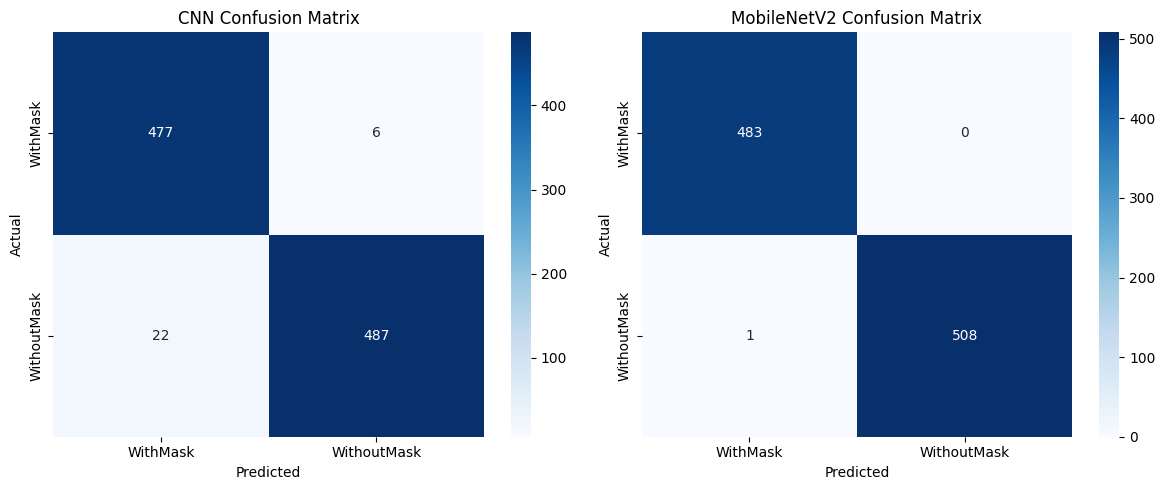

In [32]:
# Step 4: Confusion Matrices with Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

models = ['CNN', 'MobileNetV2']
predictions = [cnn_pred_classes, mobilenet_pred_classes]

for i, (model, pred) in enumerate(zip(models, predictions)):
    cm = confusion_matrix(true_labels, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=axes[i])
    axes[i].set_title(f'{model} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Note: ResNet50 confusion matrix will be added once training is complete

In [33]:
# Step 5: Model Comparison Summary
print("\n=== Final Model Comparison ===")
print(f"{'Model':<12} {'Accuracy':<10} {'Loss':<8}")
print("-" * 30)
print(f"{'CNN':<12} {cnn_accuracy:<10.4f} {cnn_loss:<8.4f}")
print(f"{'MobileNetV2':<12} {mobilenet_accuracy:<10.4f} {mobilenet_loss:<8.4f}")
# print(f"{'ResNet50':<12} {resnet_accuracy:<10.4f} {resnet_loss:<8.4f}")

# Determine best model (among currently evaluated models)
best_model = max([('CNN', cnn_accuracy), ('MobileNetV2', mobilenet_accuracy)], key=lambda x: x[1])
print(f"\n🏆 Best performing model (so far): {best_model[0]} with {best_model[1]:.4f} accuracy")
print("\n📝 Note: ResNet50 results will be added once training is complete")


=== Final Model Comparison ===
Model        Accuracy   Loss    
------------------------------
CNN          0.9718     0.0912  
MobileNetV2  0.9990     0.0036  

🏆 Best performing model (so far): MobileNetV2 with 0.9990 accuracy

📝 Note: ResNet50 results will be added once training is complete
